# PHYS-467 — First Graded Homework - 2025
## Peucelle Victor 


**Important disclaimers for this graded homework**:
- For *exercise 1 and 2*  you may only use `numpy`, and `matplotlib`. No other packages allowed. Keep code clear and concise. For *exercise 3*, you may use `sklearn`.

- Random numbers are used in this homework and results may reasonably fluctuate due to finite-size effects. This was chosen in order not to slow down the code cells running time and is of course taken into account in the correction and evaluation. We would appreciate it if you could **fix random seeds** for reproducibility and testing in the correction (see the `np.random.seed` module).

- We will run your notebook again, therefore you should make sure before submitting it on moodle, that **all code cells can be executed in order without errors**. Verify this before uploading, since we may deduce points for notebooks that fail to execute.

- In order to successfully complete this homework we **strongly** advice to look carefully to the theory lecture notes (on Moodle) of the course, the lectures in class and the tutorials.


In [1]:
# do not modify this cell
import numpy as np
import matplotlib.pyplot as plt
import random
np.random.seed(42)

# Exercise 1 (11 pts): **Robust Regression with Huber Loss and Outliers**

In this first graded homework we study linear regression over data which have outliers. We investigate how the typical losses studied in class perform over such data and we also consider new robust losses (Huber), including **L2 (Ridge)** and **L1 (Lasso)** regularization.
This first homework, the setting and methodologies are inspired by the work by M.Vilucchio et al. in:
https://proceedings.mlr.press/v238/vilucchio24a/vilucchio24a.pdf

However, no need to read and understand the article to complete the homework.

**Notation.** Consider some input data $\boldsymbol{x}_\mu \in\mathbb R^d$ with $\mu = 1,\dots,n$ samples. We work in a supervised setting, namely to each datapoint is associated a label $y_\mu \in\mathbb R$ for each sample. The parameters to learn are an estimate of the weights $\boldsymbol{w}\in\mathbb R^d$ in a linear regression task on the supervised data model:
\begin{equation}
\hat{y}_\mu(w;x_\mu) = \frac{x_\mu^\top w}{\sqrt{d}}
\end{equation}
We define the residual as the difference between the labels and our estimate in the training set
\begin{equation}r_\mu=y_\mu-\hat{y}_\mu\end{equation}

As usual, we estimate the best weights that map the input data $\boldsymbol{x}_{\mu}$ to the labels $y_\mu$ by minimizing the empirical risk (ERM).
The training loss, namely the objective function to minimize is defined with respect to the weights $w$ of the linear regression as:
$$
\mathcal L(w)=\frac{1}{n}\sum_{\mu=1}^n \ell\!\big(y_\mu-\hat{y}_\mu(w;x_\mu)\big)\;+\;\lambda\,\mathcal R(\boldsymbol{w}). \qquad \qquad (\text{Eq}. 2)
$$
Where $\mathcal R(w)$ is a regularizing function and is equal to  $ \mathcal R(w)= \tfrac12 \| \boldsymbol{w}\|_2^2$ for L2 or $ \mathcal R(w) = \|\boldsymbol{w}\|_1 $ for L1 regularizations. $\lambda$ is the regularization strength.

The loss function that takes in the residual, $\ell(r)$, that we focus on is the **Huber loss** with scale $a$ (with $a>0$). It is defined by the formula:
\begin{equation}
    \ell^{\textrm{HUBER}}_a(r)=
    \begin{cases}
        \frac{1}{2}r^2,& |r|< a\\[4pt]
        a|r|-\frac{a^2}{2},& |r|\ge a
    \end{cases} \qquad (\text{Eq}. 1)
\end{equation}
Its composition favours learning in settings where the dataset is polluted with outliers that are not aligned with the true underlying distribution that one wants to learn.

## 1.1) Theory: MSE vs MAE vs Huber (1.5 pts)

Previously, during the course lectures and tutorials we mainly used the Mean Square Error (MSE) loss, i.e. $ \ell^{\textrm MSE}(r) = r^2 $. Another commonly used loss is the Mean Absolute Error (MAE), defined by $\ell^{\textrm MAE}(r) = |r|$ for each sample and dimension of the output.
The goal of this exercise is to understand the impact that these different losses have on learning.

Outlier data points in linear regression are observations whose residuals deviate substantially from the fitted model, indicating they do not follow the general linear trend and may unduly influence the estimated coefficients.

**(a)** Explain why the MSE is generally sensitive to the presence of outliers in a dataset while the MAE is more robust to the presence of such extreme data.  

**(b)** State a drawback of MAE when computing the gradients for an absolute value loss. How is this drawback handled algorithmically in those cases?

**(c)** Explain *why* Huber is a useful compromise between the two losses. How to appropriately choose the parameter $a$ in general given a dataset with outlier datapoints? Give an intuitive response, no need to write math here.

> *Answer succinctly (maximum 5 lines for each point).*



**SOLUTION**

--- 

(a) **Sensitivity of MSE vs. robustness of MAE**

- The Mean Squared Error (MSE) is defined as  
  $$\ell^{\mathrm{MSE}}(r) = r^2 $$
  Since it squares the residuals, large errors are penalized quadratically, while smaller errors contribute much less to the loss. Consequently, a few outliers can dominate the objective and pull the fitted model toward them, making the Mean Squared Error highly sensitive to outliers.

- The Mean Absolute Error (MAE) is defined as  
  $$\ell^{\mathrm{MAE}}(r) = |r|$$
  Here, errors increase linearly with the residual. Outliers therefore have a limited influence, making MAE more robust to extreme data points.

In other words, MSE is preferable when we want the model to strongly penalize large deviations, for example when outliers are meaningful and should influence the model’s parameters. Conversely, MAE is more suitable when outliers are considered noise and should not distort the learned relationship.

*Source: [Google Machine Learning Crash Course – Linear Regression Loss](https://developers.google.com/machine-learning/crash-course/linear-regression/loss?hl=fr)*


(b) **Drawback of MAE for gradients**

The Mean Absolute Error (MAE) involves the absolute value function, whose derivative is defined as:
$$
\frac{d}{dr}|r| =
\begin{cases}
1, & r > 0,\\
-1, & r < 0,\\
\text{undefined}, & r = 0.
\end{cases}
$$

At $r = 0$, the derivative is undefined because the function has a sharp corner (or kink) at that point. This lack of smoothness can pose difficulties for gradient-based optimization methods, which rely on continuous and well-defined gradients to update parameters efficiently. Moreover, this nondifferentiability mainly affects the optimization speed rather than the correctness of the learned model.

In practice, this issue is addressed in one of two ways. First, optimization algorithms often use the concept of subgradients, where any value within the interval $[-1, 1]$ is treated as a valid gradient at $r = 0$. This allows training to proceed even when the true derivative is undefined. Alternatively, some implementations replace the absolute value with a smooth approximation (for instance, using a small quadratic region near zero) to make the loss function differentiable everywhere and ensure more stable convergence.


(c) **Why the Huber loss is a useful compromise**

The Huber loss provides a balance between the sensitivity of the Mean Squared Error (MSE) and the robustness of the Mean Absolute Error (MAE). For small residuals, the loss behaves like MSE, increasing quadratically with the error. This ensures smooth optimization and precise fitting when the data are clean and well-behaved. For large residuals, however, the Huber loss switches to a linear form, similar to MAE, which prevents outliers from having an excessive influence on the model.

This dual behavior makes the Huber loss a robust yet smooth compromise. It remains sensitive enough to small errors to fine-tune the model’s predictions, while at the same time reducing the impact of large deviations caused by outliers or noisy data.

The parameter $a$ controls the transition point between the quadratic and linear regions. If the dataset contains many outliers, a smaller value of $a$ should be chosen so that the loss switches earlier to the MAE-like regime, increasing robustness. Conversely, when the data are mostly clean and reliable, a larger value of $a$ allows the model to behave more like MSE, preserving sensitivity and ensuring smooth convergence.

---

## 1.2) Data generator (1.5 pts)

The dataset we use in this excercise has the following form.
For each sample $\mu = 1,\dots,n$:

$$
\boldsymbol{x}_\mu \sim \mathcal N(0,I_d),\quad y_\mu =
\begin{cases}
\frac{1}{\sqrt{d}}\boldsymbol{x}_{\mu}^{\top} \boldsymbol{w}^\star + z^\mu_{\text{in}},\quad z^\mu_{\text{in}}\sim\mathcal N(0,\Delta_{\text{in}}), & \text{w.p. } 1-\varepsilon\\
 z^\mu_{\text{out}},\qquad \qquad \quad z^\mu_{\text{out}}\sim\mathcal N(m,\Delta_{\text{out}}), & \text{w.p. } \varepsilon
\end{cases} \quad (\text{Eq}.2)
$$

We hence work in a supervised setting, in which we have some input datapoints $\boldsymbol{x}_\mu$ and for each of then we construct labels $y_\mu$ from a linear regression model, namely from a ground truth vector $\boldsymbol{w}^\star$. In particular, we generate a fraction $1-\varepsilon$ labels from a standard (noisy) linear regression model (the scaling factor $\sqrt{d}$ is for convenience, to assure the scalar product $\boldsymbol{x}_{\mu}^{\top}\boldsymbol{w}^\star$ is small).

The parameter $\varepsilon>0$ stems for the fraction of outliers data. In this exercise we model outlier data as just some gaussian noise with a non-zero (large) mean $m\geq 0$ and variance $\Delta_{\rm out}\geq 0$ that are known.

Importantly, all the $d$ entries of the ground truth vector $\boldsymbol{w}^\star$ are uniformly sampled at random and are equal to $\pm 1$ with probability $\tfrac12$.

**Ex. 1.2.1 (1.0 pts):**
1. Write a function `make_w_star(d)` that returns a vector of size $d$ sampled from $\boldsymbol{w}^\star$, with components described as above.
2. Write a function `make_mixture_regression(n, d, w_star, eps, m, Delta_in, Delta_out)` that returns `(X,y,mask)` where `mask` is a boolean array (True for the outlier data branch).
2. Generate one trial dataset only for visualization purposes. Use here $n=1000,d=1000,\varepsilon=0.3,m=5.0,\Delta_{\text{in}}=0.5,\Delta_{\text{out}}=5.0$.
3. Make a scatter plot of $(\boldsymbol{x}_\mu^\top \boldsymbol{w}^\star / \sqrt{d}, y_\mu)_\mu$ with two colors for the two branches of outlier and non-oulier data.

**Note:** Generating the data correctly is of crucial importance for the success of this graded homework, as all the subsequent results strongly depend on the data model. For this reason, on Moodle you can find a data demo `demo_data.csv` where the data are exactly generated as specified above (with of course a different realisation of $\boldsymbol{w}_\star$ and $\boldsymbol{x}$ which differ everytime as they are random). The plot you should obtain with your data-generating function must be similar to that one shown below here.

In [2]:
# —-- Generate weight vector w_star —--
def make_w_star(d):
    """Generate a random weight vector w_star of dimension d with entries +/-1."""
    return np.random.choice([-1, 1], size=d)

# —-- Generate mixture regression dataset —--
def make_mixture_regression(n, d, w_star, eps, m, Delta_in, Delta_out):
    """Generate a mixture regression dataset (X, y, mask)."""
    
    X = np.random.normal(0, 1, (n, d))
    mask = np.random.rand(n) < eps

    y = X.dot(w_star) / np.sqrt(d) + np.random.normal(0, np.sqrt(Delta_in), size=n) # Inliers
    y[mask] = np.random.normal(m, np.sqrt(Delta_out), size=np.sum(mask)) # Outliers

    return X, y, mask

[INFO] Generating mixture regression dataset with n=1000, d=1000, eps=0.3, m=5.0, Delta_in=0.5, Delta_out=5.0


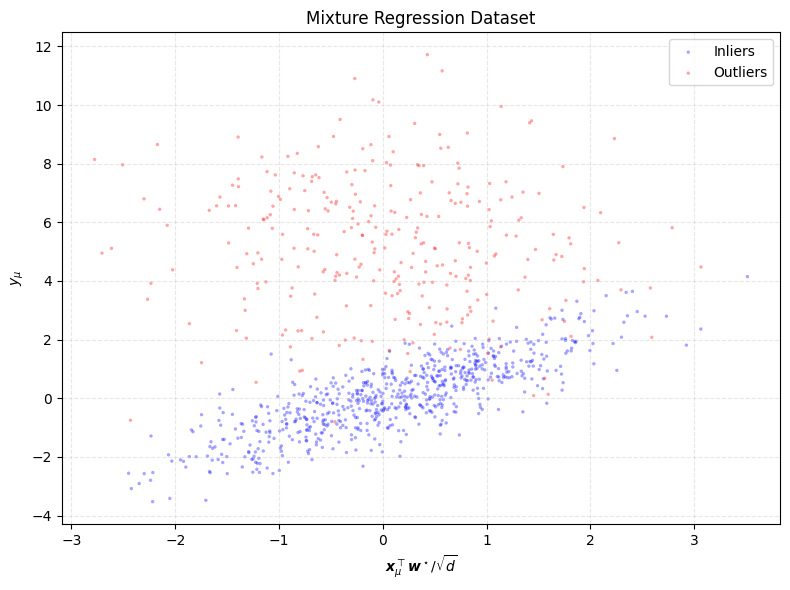

In [3]:
# --- PARAMETERS ---
n = 1000            # number of samples
d = 1000            # number of features
eps = 0.3           # fraction of outliers
m = 5.0             # mean of outlier distribution
Delta_in = 0.5      # variance of inlier noise
Delta_out = 5.0     # variance of outlier noise
print(f"[INFO] Generating mixture regression dataset with n={n}, d={d}, eps={eps}, m={m}, Delta_in={Delta_in}, Delta_out={Delta_out}")

# --- GENERATE DATA ---
w_star = make_w_star(d)
X, y, mask = make_mixture_regression(n, d, w_star, eps, m, Delta_in, Delta_out)

# --- VISUALIZATION ---
linear_proj = X.dot(w_star) / np.sqrt(d)
plt.figure(figsize=(8, 6))
plt.scatter(linear_proj[~mask], y[~mask], color='blue', alpha=0.35, label='Inliers', s=6, edgecolors="none")
plt.scatter(linear_proj[mask], y[mask], color='red', alpha=0.35, label='Outliers',  s=6, edgecolors="none")
plt.xlabel(r'$\boldsymbol{x}_\mu^\top \boldsymbol{w}^\star / \sqrt{d}$')
plt.ylabel(r'$y_\mu$')
plt.title('Mixture Regression Dataset')
plt.tight_layout()
plt.legend()
plt.grid(alpha = 0.3, linestyle = '--')
plt.show()

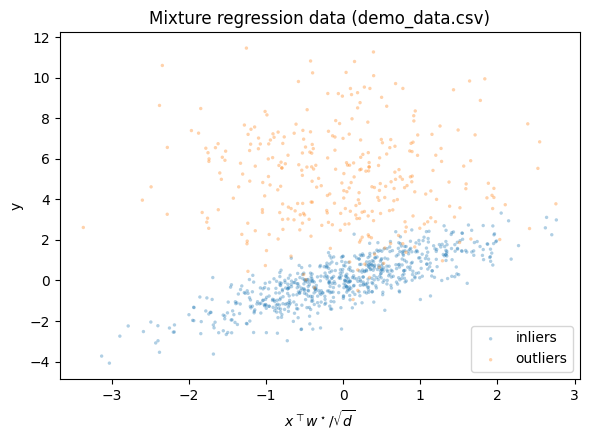

In [4]:
# Load and plot data-demo. Ensure the datafile "demo_data.csv" is in the correct folder when plotting
#load csv data
import pandas as pd

csv_path = "demo_data.csv"
df = pd.read_csv(csv_path)

# Note: this csv file does not contain X or w_star but rather the projection proj = X @ w_star / np.sqrt(d)
# proj is a vector with n samples components, so as y.
inliers  = df["mask"] == 0
outliers = df["mask"] == 1

plt.figure(figsize=(6.0, 4.5))
plt.scatter(df.loc[inliers, "proj"],  df.loc[inliers, "y"],  s=6, alpha=0.35, label="inliers",  edgecolors="none")
plt.scatter(df.loc[outliers, "proj"], df.loc[outliers, "y"], s=6, alpha=0.35, label="outliers", edgecolors="none")
plt.xlabel(r"$x^\top w^\star / \sqrt{d}$")
plt.ylabel("y")
plt.title("Mixture regression data (demo_data.csv)")
plt.legend()
plt.tight_layout()
plt.show()


**Ex. 1.2.2 (0.5 pts):**
In this exercise you have to create the synthetic dataset you will use throughout the next points.
The upshot is that you *know* the $\boldsymbol{w}^\star$ that generated your data. This is not the case in real-world settings, but it will help us to understand the Huber loss better.

For the synthetic dataset you will generate a ground-truth vector $\boldsymbol{w}^\star \in \mathbb{R}^d$, where each component is i.i.d. and sampled from $\pm1$ with equal probability.
This will be the same for the training set, the validation set and the test set:
- Create a training set $\mathcal{D}_{\text tr} = \{ X_{\text tr}, y_{\text tr} \}$ of $n_{\text tr}=6000$ samples using $d=500,\varepsilon=0.3,m=20.0,\Delta_{\text{in}}=0.5,\Delta_{\text{out}}=5$.
- Create a validation set $\mathcal{D}_{\text val} = \{ X_{\text val}, y_{\text val} \}$ of $n_{\text val}=2000$ samples with only unpolluted data, namely with $d=500,\varepsilon=0.0,m=0.0,\Delta_{\text{in}}=0.0,\Delta_{\text{out}}=0.0$.
- Create a test set $\mathcal{D}_{\text ts} = \{ X_{\text ts}, y_{\text ts} \}$ of $n_{\text ts}=2000$ samples with only unpolluted data, namely with $d=500,\varepsilon=0.0,m=0.0,\Delta_{\text{in}}=0.0,\Delta_{\text{out}}=0.0$.

Hence, we use a training set which contains outliers with large mean and noise. In this sense **we have a "polluted" training dataset** ($\epsilon>0$) from which we want to estimate a direction $\hat{w}$ that we hope is as close as possible to the original one $\boldsymbol{w}^\star$.
For this reason, **the validation and test set we use are "clean"** from any outliers ($\epsilon=0$).
In addition, there is no noise on the inliers for validation and test ($\Delta_{in} = 0$), for the same reason that we want to uncover the *true* $\boldsymbol{w}^\star$.

**Small note:** We use equivalently the notation $X \in \mathbb{R}^{n \times d}$ as the input data matrix with n i.i.d. gaussian samples, each of them a vector of dimension d. Equivalently we write $\boldsymbol{x}_\mu \in \mathbb{R}^d$ vectors with $\mu=1,\dots,n$.


In [5]:
# --- PARAMETERS FOR DIFFERENT DATASETS ---

d = 500            # data dimension (fixed for all datasets)

# parameters for training dataset
n_tr = 6000        # number of training samples
eps_tr = 0.3       # fraction of outliers
m_tr = 20.0        # outlier mean
Delta_in_tr = 0.5  # inlier noise std
Delta_out_tr = 5.0 # outlier noise std

print(f"[INFO] Generating training dataset with n={n_tr}, d={d}, eps={eps_tr}, m={m_tr}, Delta_in={Delta_in_tr}, Delta_out={Delta_out_tr}")

# parameters for validation dataset
n_val = 2000        # number of training samples
eps_val = 0.0       # fraction of outliers
m_val = 0.0         # outlier mean
Delta_in_val = 0.0  # inlier noise std
Delta_out_val = 0.0 # outlier noise std

print(f"[INFO] Generating validation dataset with n={n_val}, d={d}, eps={eps_val}, m={m_val}, Delta_in={Delta_in_val}, Delta_out={Delta_out_val}")

# parameters for testing dataset
n_ts = 2000         # number of training samples
eps_ts = 0.0        # fraction of outliers
m_ts = 0.0          # outlier mean
Delta_in_ts = 0.0   # inlier noise std
Delta_out_ts = 0.0 # outlier noise std

print(f"[INFO] Generating testing dataset with n={n_ts}, d={d}, eps={eps_ts}, m={m_ts}, Delta_in={Delta_in_ts}, Delta_out={Delta_out_ts}")

# --- GENERATE DATA ---

# Generate true weight vector
w_star = make_w_star(d)
print('[INFO] True weight vector w_star generated.')

# Generate datasets
X_tr, y_tr, mask_tr = make_mixture_regression(n_tr, d, w_star, eps_tr, m_tr, Delta_in_tr, Delta_out_tr)
X_val, y_val, mask_val = make_mixture_regression(n_val, d, w_star, eps_val, m_val, Delta_in_val, Delta_out_val)
X_ts, y_ts, mask_ts = make_mixture_regression(n_ts, d, w_star, eps_ts, m_ts, Delta_in_ts, Delta_out_ts)
print('[INFO] Training, validation, and testing datasets generated.')

[INFO] Generating training dataset with n=6000, d=500, eps=0.3, m=20.0, Delta_in=0.5, Delta_out=5.0
[INFO] Generating validation dataset with n=2000, d=500, eps=0.0, m=0.0, Delta_in=0.0, Delta_out=0.0
[INFO] Generating testing dataset with n=2000, d=500, eps=0.0, m=0.0, Delta_in=0.0, Delta_out=0.0
[INFO] True weight vector w_star generated.
[INFO] Training, validation, and testing datasets generated.


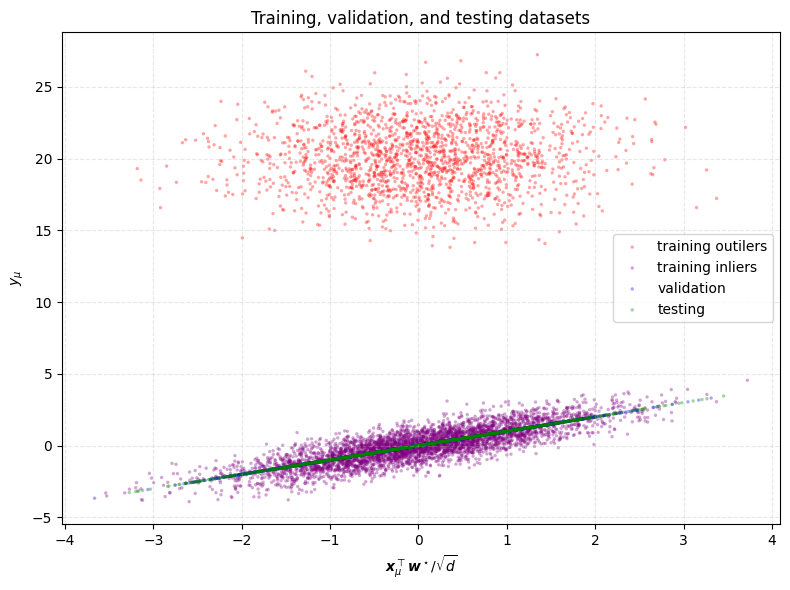

In [6]:
# --- VISUALIZATION : Generated Datasets ---
linear_proj_tr = X_tr.dot(w_star) / np.sqrt(d)
linear_proj_val = X_val.dot(w_star) / np.sqrt(d)
linear_proj_ts = X_ts.dot(w_star) / np.sqrt(d)
plt.figure(figsize=(8, 6))
plt.scatter(linear_proj_tr[mask_tr], y_tr[mask_tr], color='red', alpha=0.35, label='training outilers',  s=6, edgecolors="none")
plt.scatter(linear_proj_tr[~mask_tr], y_tr[~mask_tr], color='purple', alpha=0.35, label='training inliers',  s=6, edgecolors="none")
plt.scatter(linear_proj_val, y_val, color='blue', alpha=0.35, label='validation',  s=6, edgecolors="none")
plt.scatter(linear_proj_ts, y_ts, color='green', alpha=0.35, label='testing',  s=6, edgecolors="none")
plt.xlabel(r'$\boldsymbol{x}_\mu^\top \boldsymbol{w}^\star / \sqrt{d}$')
plt.ylabel(r'$y_\mu$')
plt.title('Training, validation, and testing datasets')
plt.tight_layout()
plt.legend()
plt.grid(alpha = 0.3, linestyle = '--')
plt.show()

## 1.3) Huber Loss: mapping to MSE and MAE (1 pts)

**(a)** Write the minimization problem to solve in order to find $\hat{w}$ from the training set $\mathcal{D}= \{ \boldsymbol{x}_\mu , y_\mu\}_{\mu=1}^n$. Use the $\text{argmin}$ function, put an L2 regularization on the weights with strength $\lambda/2$ and specify the Huber loss structure. Use the $1/n$ term only in the data part of the loss.

**(b)** What do you expect to happen intuitively to the Huber loss and consequently to the ERM problem when $a \to \infty$ ?


**(c)** What do you expect to happen intuitively to the Huber loss and consequently to the ERM problem when $a \to 0$ ?


**Hint:** Think about the connections between Huber and MSE/MAE losses.

**Note:** Answer each point in maximum 5 lines, eventual formulas and computations are not included in this limit. Apart from point a), in point b) and c) you do not necessarily have to write mathematical expressions to get full points.

**SOLUTION**

--- 

(a) **Huber loss minimization with $L_2$ regularization**

The Huber loss for a residual $r_\mu = y_\mu - \frac{\boldsymbol{x}_\mu^\top \hat w}{\sqrt{d}}$ is:

\begin{equation}
	l_a(r) =
	\begin{cases}
		\frac{1}{2} r^2, & \text{if } |r| \le a \\
		a |r| - \frac{1}{2} a^2, & \text{if } |r| > a
	\end{cases}
\end{equation}

Notice that $l_a(r)$ is differentiable everywhere, unlike MAE.

Including $L_2$ regularization with strength $\lambda/2$, the empirical risk minimization problem is:

\begin{equation}
	\hat w = \arg\min_{w \in \mathbb{R}^d} \; \left[ \frac{1}{n} \sum_{\mu=1}^n l_a\left(y_\mu - \frac{\boldsymbol{x}_\mu^\top w}{\sqrt{d}} \right) + \frac{\lambda}{2} \|w\|_2^2 \right]
\end{equation}


(b) **Intuition for $a \to \infty$**

When the parameter $a$ is very large, the Huber loss almost never enters the linear regime, that is, $|r| \le a$ for almost all residuals. In this case, the Huber loss behaves like the pure mean squared error (MSE), 
$$l_a(r) \approx \tfrac{1}{2} r^2$$
Consequently, minimizing the Huber loss with a very large $a$ is equivalent to minimizing the regularized MSE. Intuitively, outliers have a strong influence because the quadratic penalty increases proportionally to $r^2$.


(c) **Intuition for $a \to 0$**

When the parameter $a$ is very small, the Huber loss almost immediately enters the linear regime, even for small residuals. In this regime, the Huber loss is effectively equivalent to the mean absolute error (MAE), differing only by an additive constant $a^2 / 2$ that can safely be ignored :
$$l_a(r) \approx a |r| $$
Consequently, minimizing the Huber loss with a very small $a$ is equivalent to minimizing the regularized MAE. Intuitively, the model becomes more robust to outliers, since large residuals contribute linearly rather than quadratically to the loss.

---

## 1.4) Gradients: Huber + L2 and Huber + L1 (1 pts)

**(a)** Derive the gradient of the Huber loss $\nabla_{\boldsymbol{w}} \ell_a(y-\frac{\boldsymbol{x}^\top \boldsymbol{w}}{\sqrt{d}})$.  
**(b)** Write the full gradient/subgradient of the whole $\mathcal L(w)$ (data+regularization term) in (Eq.2) for:
- **L2**: $\mathcal R(w)=\frac{1}{2}\|w\|_2^2$ — standard gradient.
- **L1**: $\mathcal R(w)=\|w\|_1$ — use appropriate subgradients in complicated points.


**SOLUTION**

---

(a) **Gradient of the Huber loss**

We first derive the gradient of the Huber loss with respect to the residual $ r = y - \frac{\vec{x}^\top \vec{w}}{\sqrt{d}} $:

$$
\frac{\partial}{\partial r}\, \ell_a(r) =
\begin{cases}
    r, & |r| < a, \\[4pt]
    a \, \mathrm{sign}(r), & |r| \ge a.
\end{cases}
$$

By the chain rule, since
$$
r = y - \frac{\vec{x}^\top \vec{w}}{\sqrt{d}} 
\quad \Longrightarrow \quad 
\nabla_{\vec{w}}\, r = -\frac{\vec{x}}{\sqrt{d}},
$$
we have:
$$
\nabla_{\vec{w}}\, \ell_a\!\left(y - \frac{\vec{x}^\top \vec{w}}{\sqrt{d}}\right)
= \frac{\partial}{\partial r}\,\ell_a(r) \cdot \nabla_{\vec{w}} r
= -\,\frac{\frac{\partial}{\partial r}\,\ell_a(r)}{\sqrt{d}}\,\vec{x}.
$$

Hence,
$$
\boxed{
\nabla_{\vec{w}}\, \ell_a\!\left(y - \frac{\vec{x}^\top \vec{w}}{\sqrt{d}}\right) =
\begin{cases}
    -\,\dfrac{r}{\sqrt{d}}\, \vec{x}, & |r| < a, \\[6pt]
    -\,\dfrac{a}{\sqrt{d}}\, \mathrm{sign}(r)\, \vec{x}, & |r| \ge a.
\end{cases}
}
$$


(b) **Full gradient with regularization**

For $ L_2 $ regularization:
$$
\mathcal{L}^{\mathrm{reg}}(\vec{w}) = \tfrac{1}{2}\|\vec{w}\|_2^2 
\quad \Longrightarrow \quad 
\nabla_{\vec{w}} \mathcal{L}^{\mathrm{reg}}(\vec{w}) = \vec{w}.
$$

Therefore, the total gradient is:
$$
\boxed{
\nabla_{\vec{w}}\, \mathcal{L}(\vec{w}) =
\frac{1}{n}\sum_{i=1}^n \nabla_{\vec{w}}\, \ell_a\!\left(y_i - \frac{\vec{x}_i^\top \vec{w}}{\sqrt{d}}\right)
+ \lambda\, \vec{w}.
}
$$

For $ L_1 $ regularization:
$$
\mathcal{L}^{\mathrm{reg}}(\vec{w}) = \|\vec{w}\|_1
\quad \Longrightarrow \quad 
\partial \mathcal{L}^{\mathrm{reg}}(\vec{w})_j =
\begin{cases}
    1, & w_j > 0, \\[2pt]
   -1, & w_j < 0, \\[2pt]
   [-1,1], & w_j = 0.
\end{cases}
$$

Thus, the subgradient of the total loss is:
$$
\boxed{
\partial_{\vec{w}}\, \mathcal{L}(\vec{w}) =
\frac{1}{n}\sum_{i=1}^n \nabla_{\vec{w}}\, \ell_a\!\left(y_i - \frac{\vec{x}_i^\top \vec{w}}{\sqrt{d}}\right)
+ \lambda\, \vec{g},
\quad
g_j \in
\begin{cases}
\{1\}, & w_j > 0, \\[2pt]
\{-1\}, & w_j < 0, \\[2pt]
[-1,1], & w_j = 0.
\end{cases}
}
$$

At coordinates where $ w_j = 0 $, the subgradient can take any value in $[-1, 1]$.  
In practice, optimization algorithms such as subgradient descent or proximal methods handle this automatically.

---

## 1.5) GD with cross-validation; test error vs $\alpha=n/d$ (6.0 pts)
In this coding part, we want to compare the performances of the Huber loss on a test set through the generalization error.
We want to compare the Huber loss with L2 regularization, with the performance of the standard square loss with L2 regularization (ordinary Ridge regression).

The metric we use to assess the quality of the estimator $\hat{w}$ (solution of the ERM problem you wrote in Ex. (1.3.a) found with a Gradient Descent algorithm, is the generalization error over a fresh test set (constructed with the same rule as above):

\begin{equation}
E_{\textrm {gen}}(\hat{w}) = \mathbb{E}_{(x_{\textrm{new}}, y_{\textrm {new}})}
 \Bigl[ \Bigl(y_{\textrm {new}} - \frac{x^\top _{\textrm {new}} \hat{w}}{\sqrt{d}}   \Bigr)^2 \Bigr] = \frac{1}{n_{\textrm test}} \sum_{\mu =1 }^{n_{\textrm test}} (y_{\mu} -\frac{x^\top _{\mu} \hat{w}}{\sqrt{d}} )^2 \qquad (\textrm{Eq}.3)
\end{equation}






Use the data generated in point Ex. (1.2.2) with $d=500$. Use all 3 datasets for training, validating and testing.

In the following we define the "sample complexity" $\alpha$ as the ratio between the number of training samples $n_{\text tr}$ and the data dimension $d=500$, namely $\alpha = n/d$. In particular, the dataset you already constructed $\mathcal{D}_{\text tr}$ contains $6000$ datapoints in total, so the maximum value $\alpha$ can take is $\alpha_{\text max}=6000/500 =12.0$. Given a value of $\alpha$ below, you have to sample uniformly at random $n_{\text tr}=\lfloor \alpha d \rfloor$ datapoints from the whole training set $\mathcal{D}_{\text tr} = \{X_{\text tr}, y_{\text tr} \}$ .

In this point, take five values of the sample complexity, namely $\alpha \in \{ 0.2, 0.3, 0.5, 1.0, 3.0 \}$.




**Ex. 1.5.1 (2.5 pts):**

Implement the Gradient Descent algorithm for the Huber loss + Ridge regularization. Use fixed regularization strenght $\lambda=0.01$.

Perform a cross-validation (on the validation set constructed previously) with respect to the scale parameter $a$ of the Huber loss: in particular, try the values of $a\in \{0.5, 1.0, 1.5, 2.0, 5.0, 10.0 \}$ and print the one which gives the best validation error.

Note that this procedure is not what is commonly referred as k-fold cross-validation, but rather an "independent set" validation.
  
After validating, pick the best value of $a$ for each value of $\alpha$ and compute the generalization/test error of the learnt $\hat{w}$ in the test set.

Do the same procedure for all the 5 values of $\alpha \in \{ 0.2, 0.3, 0.5, 1.0, 3.0\}$.

In the code cell below, store all the 5 specific partitions of the training sets you use for each $\alpha$, as you will need to use exactly the same training sets (as well with the test set generated in Ex. (1.2.2)) in the following Ex. (2.2.3) on Monte-Carlo sampling, in order to compare the test error and overlap achieved by Huber optimization with the one achieved by Metropolis.

Compute the test error in (Eq.3). Along with the test error, also compute and print the overlap of your estimate with respect to the ground truth defined as:
$$ \text{Overlap} = \frac{\hat{w} \cdot w^\star}{|| \hat{w}||_2 ||w^\star||_2 }  $$
The prints (one for each $\alpha$) must be of the format:
**"$\alpha$=... | best $a$=... | val_err=... | test_err = ... | overlap = ..."**

**Notes:** Use a simple step schedule. Code every function from scratch using only numpy or matplotlib (sklearn is not allowed here).
Use all the precautions below (important for obtaining full points):
- Use $\eta=0.01$ and $T_{\text max}=10000$ maximum gradient descent steps.
- Use a clever convergence criterium of your algorithm. In particular, use a tolerance equal to ${\text tol}=10^{-5}$ on the consecutive iterates of the algorithm. Initialize the weights at time $w^{t=0}$ with all zero components.
- Be sure your algorithm is reaching convergence, hitting the tolerance of $10^{-5}$ among consecutive training steps in the objective loss, so that GD is reaching the global minimum of the loss. Implement convergence checks.

**Disclaimer:** Optimizing Huber loss may be slow per-se, you may have to be patient when debugging depending on your computational resources.

In [7]:
# --- HYPERPARAMETERS ---

# Model parameters
d = 500                                     # data dimension
lmbda = 0.01                                # lambda : regularization parameter
alpha_list = [0.2, 0.3, 0.5, 1.0, 3.0]      # alpha values 
a_list = [0.5, 1.0 , 1.5, 2.0, 5.0, 10.0]   # a values

print(f"[INFO] Model parameters set: d={d}, lambda={lmbda}, alpha_list={alpha_list}, a_list={a_list} \n")

# Optimizer parameters 
lr = 0.01                            # eta : learning rate
T_max = 10000                        # maximu gradient descent iterations
tol = 1e-5                           # tolerance for stopping criterion

# Storage variables
partitions = {}                      # to store the indices of the training samples used for each alpha
huber_results = {}                   # store results per alpha

# --- Gradient Descent: Huber loss ---
for alpha in alpha_list:
    
    n_alpha_tr = int(alpha * d)                                         # number of training samples for current alpha
    idx_tr = np.random.choice(n_tr, size=n_alpha_tr, replace=False)     # randomly select training samples
    partitions[alpha] = idx_tr.copy()
    X_alpha_tr = X_tr[idx_tr]
    y_alpha_tr = y_tr[idx_tr]
    
    best_val_mse = np.inf
    best_a = None
    best_w = None
    best_it = None

    for a in a_list:
        w = np.zeros(d)
        train_losses = []

        for it in range(T_max):
            y_pred = X_alpha_tr.dot(w)/np.sqrt(d)
            residual = y_pred - y_alpha_tr
            psi = np.where(np.abs(residual) <= a, residual, a * np.sign(residual))
            gradient = (1 / n_alpha_tr) * (1/np.sqrt(d)) * X_alpha_tr.T.dot(psi) + lmbda * w

            w -= lr * gradient

            huber_loss = np.where(np.abs(residual) <= a,
                                0.5 * residual**2,
                                a * (np.abs(residual) - 0.5 * a))
            train_loss = np.mean(huber_loss) + 0.5 * lmbda * np.linalg.norm(w)**2
            train_losses.append(train_loss)

            if it > 0 and abs(train_losses[-1] - train_losses[-2]) < tol:
                break

        y_val_pred = X_val.dot(w)/np.sqrt(d)
        val_mse = np.mean((y_val_pred - y_val) ** 2)

        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_a = a
            best_it = it
            best_w = w.copy()

    y_ts_pred = X_ts.dot(best_w)/np.sqrt(d)
    test_mse = np.mean((y_ts_pred - y_ts) ** 2)
    
    if np.linalg.norm(best_w) == 0 or np.linalg.norm(w_star) == 0:
        overlap = 0.0
    else:
        overlap = best_w @ w_star / (np.linalg.norm(best_w) * np.linalg.norm(w_star))

    huber_results[alpha] = {
        "best_a": best_a,
        "val_err": best_val_mse,
        "test_err": test_mse,
        "overlap": overlap,
        "it": best_it,
        "idx_tr": partitions[alpha]
    }

    print(f"α = {alpha:.1f} | best a = {best_a} | val_err= {best_val_mse:.4f} | test_err= {test_mse:.4f} | overlap = {overlap:.4f}")

[INFO] Model parameters set: d=500, lambda=0.01, alpha_list=[0.2, 0.3, 0.5, 1.0, 3.0], a_list=[0.5, 1.0, 1.5, 2.0, 5.0, 10.0] 

α = 0.2 | best a = 1.0 | val_err= 0.9552 | test_err= 1.0472 | overlap = 0.1643
α = 0.3 | best a = 1.5 | val_err= 0.8742 | test_err= 0.9733 | overlap = 0.3386
α = 0.5 | best a = 1.5 | val_err= 0.9206 | test_err= 1.0035 | overlap = 0.2594
α = 1.0 | best a = 2.0 | val_err= 0.8900 | test_err= 0.9581 | overlap = 0.4236
α = 3.0 | best a = 5.0 | val_err= 0.8498 | test_err= 0.9269 | overlap = 0.4406



**Ex. 1.5.2 (1.0 pts):** In this exercise use the same exact datasets constructed in Ex. (1.2.2) and partitioned as explained at the beginning of Ex. (1.1.5).

Replace the Huber loss by a standard MSE loss. From the theory you know you have an exact formula to compute the **exact** MSE estimator $\hat{w}$ from the training set when using a squared loss with L2 regularization with strength $\lambda/2$.

Also in this case $\lambda=0.01$ is fixed, so you do not need to perform any validation in this point.
   
Compute the generalization error and overlap for the 5 values of $\alpha$ above for the MSE loss. Also in this case, compute the test error and overlap with the same formulas as above.

The 5 prints (one for each $\alpha$) must be of the format:
**"$\alpha$=... | test_err = ... | overlap = ..."**

In [8]:
# --- HYPERPARAMETERS ---

# Model parameters
d = 500
lmbda = 0.01
alpha_list = [0.2, 0.3, 0.5, 1.0, 3.0]

print(f"[INFO] Model parameters set: d={d}, lambda={lmbda}, alpha_list={alpha_list} \n")

# Storage variables
results_mse = {}

# --- Closed-form Ridge Regression ---
for alpha in alpha_list:
    n_alpha_tr = int(alpha * d)
    idx_tr = partitions[alpha]  
    X_alpha_tr = X_tr[idx_tr]
    y_alpha_tr = y_tr[idx_tr]
    
    w_hat = np.linalg.inv(X_alpha_tr.T @ X_alpha_tr / d + n_alpha_tr * lmbda / 2  * np.eye(d)) @ (X_alpha_tr.T @ y_alpha_tr) / np.sqrt(d)

    y_ts_pred = X_ts.dot(w_hat) / np.sqrt(d)
    test_mse = np.mean((y_ts_pred - y_ts) ** 2)

    if np.linalg.norm(w_hat) == 0 or np.linalg.norm(w_star) == 0:
        overlap = 0.0
    else:
        overlap = np.dot(w_hat, w_star) / (np.linalg.norm(w_hat) * np.linalg.norm(w_star))

    results_mse[alpha] = (test_mse, overlap)
    print(f"α = {alpha:.1f} | test_err = {test_mse:.6f} | overlap = {overlap:.4f}")

[INFO] Model parameters set: d=500, lambda=0.01, alpha_list=[0.2, 0.3, 0.5, 1.0, 3.0] 

α = 0.2 | test_err = 13.298002 | overlap = -0.0005
α = 0.3 | test_err = 9.249720 | overlap = 0.0968
α = 0.5 | test_err = 11.042927 | overlap = 0.0100
α = 1.0 | test_err = 8.587409 | overlap = 0.0733
α = 3.0 | test_err = 3.436375 | overlap = 0.1702


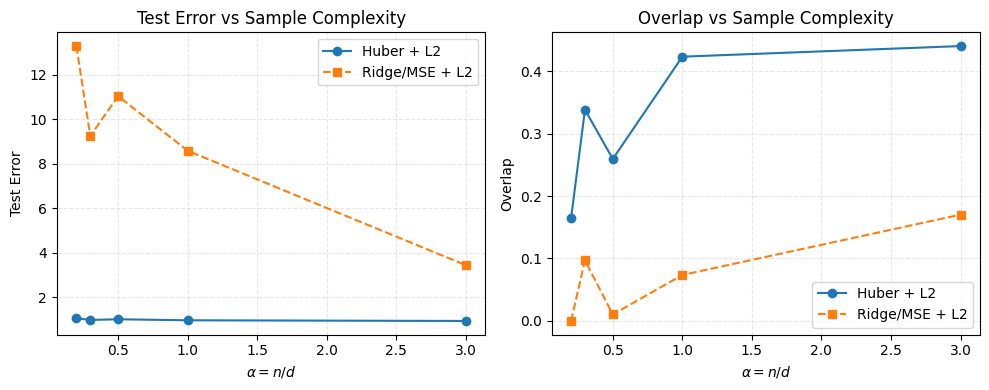

In [9]:
# --- VISUALIZATION : Huber loss vs. exact MSE ---

# extract test errors and overlaps
huber_test_err = [huber_results[alpha]["test_err"] for alpha in alpha_list]
huber_overlap  = [huber_results[alpha]["overlap"] for alpha in alpha_list]

ridge_test_err = [results_mse[alpha][0] for alpha in alpha_list]
ridge_overlap  = [results_mse[alpha][1] for alpha in alpha_list]

# Plot Test Error 
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(alpha_list, huber_test_err, 'o-', label='Huber + L2')
plt.plot(alpha_list, ridge_test_err, 's--', label='Ridge/MSE + L2')
plt.xlabel(r'$\alpha = n/d$')
plt.ylabel('Test Error')
plt.title('Test Error vs Sample Complexity')
plt.legend()
plt.grid(alpha = 0.3, linestyle = '--')

# Plot Overlap 
plt.subplot(1,2,2)
plt.plot(alpha_list, huber_overlap, 'o-', label='Huber + L2')
plt.plot(alpha_list, ridge_overlap, 's--', label='Ridge/MSE + L2')
plt.xlabel(r'$\alpha = n/d$')
plt.ylabel('Overlap')
plt.title('Overlap vs Sample Complexity')
plt.legend()
plt.grid(alpha = 0.3, linestyle = '--')

plt.tight_layout()
plt.show()

**Comment**

---

We observe that, for the Huber loss, the test error decreases as the number of training samples ($\alpha = n/d$) increases, while the overlap tends to increase. This indicates that gradient descent with the Huber loss progressively approaches the optimal vector $w_\star$ as more training data become available. Moreover, the value of optimal-$a$ tends to increase with $\alpha$, suggesting that, for larger training sets, outliers are effectively diluted and penalized less. As a result, optimal-$a$ grows, and the Huber loss behaves more like the MSE in the large-optimal-$a$ regime.

Similarly, the solution obtained with MSE shows the same trend: the test error decreases and the overlap increases with $\alpha$, reflecting an improved estimation of the target vector when more samples are used.

---

**Ex. 1.5.3 (0.5 pts):**

Compare the test errors and overlaps achieved by the MSE loss computed in the previous point above with the one achieved by the Huber loss at the optimal scale $a$. You should observe that depending on the values of $\alpha$ one of the two estimators, Huber or MSE, performs better. Which one and why?




**SOLUTION**

--- 

When comparing test errors and overlaps for Huber loss (at optimal $a$) and standard MSE (Ridge regression) across different $\alpha$, we observe a strong dependence on sample size. For small $\alpha$, Huber typically outperforms MSE because small training sets are more sensitive to outliers; the robust Huber loss limits the influence of extreme residuals, yielding lower test error and higher overlap with the ground-truth $w^\star$. As $\alpha$ increases, differences diminish since outlier effects are diluted in larger datasets, and Huber behaves more like MSE. In summary, Huber is advantageous for small datasets or noisy/polluted data, whereas MSE suffices for large, clean datasets.

--- 

**Ex. 1.5.4 (0.5 pts):**

In general machine learning problems, it may be useful to average over the initialization of the weights $w_{t=0}$ and perform independent runs of the gradient descent algorithm. In this specific Huber loss setting and for a fixed dataset, is averaging over different initializations of the weights useful or it leads to a negligible effect ?

**SOLUTION**

---

In this specific Huber loss setting with a fixed dataset, averaging over different initializations of the weights $w_{t=0}$ is generally not necessary. The Huber loss combined with $L_2$ regularization is convex in $w$, which guarantees that gradient descent will converge to the unique global minimum regardless of the starting point. Therefore, running gradient descent from different initializations will produce essentially the same solution, and averaging the results would have a negligible effect on the final estimator or the test performance. This is in contrast to non-convex problems, where multiple local minima could make initialization critical.

---

**Ex. 1.5.5 (0.5 pts):**
In this exercise we provide you three datasets in csv format (download them from Moodle and make sure they are in the same directory of your notebook in order to correctly read them). The files are called train.csv , validate.csv and test.csv and contain 3 instances of the dataset constructed exactly from the model in (Eq.2).

The values of the parameters used are not given to you and neither is the ground truth vector $\boldsymbol{w}^\star$ used to generate the data. Also here $\boldsymbol{w}^\star$ is sampled from a binary prior, where each component is sampled i.i.d. from $\pm 1$ with equal probability.

Hence, train.csv contains $n=3000$ datapoints $(X,y)$ where the input data $X$ have $d=1000$, while validation.csv and test.csv contain $n=2000$ samples of the same format.

The data in each csv are saved with X as an n times d matrix, while the last column are the labels y.


As a first exercise, load correctly the data and store the train, validation and test set input data and labels inside variables named (X_tr_real,y_tr_real), (X_vl_real,y_vl_real), (X_ts_real,y_ts_real). Check the shapes of these objects.

**Note:** the library pandas here is allowed.

In [10]:
# --- Load Datas (CSV) ---
import pandas as pd

train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("validate.csv")
test_df = pd.read_csv("test.csv")

X_tr_real, y_tr_real= train_df.iloc[:, :-1].values, train_df.iloc[:, -1].values
X_vl_real, y_vl_real= val_df.iloc[:, :-1].values, val_df.iloc[:, -1].values
X_ts_real, y_ts_real= test_df.iloc[:, :-1].values, test_df.iloc[:, -1].values

# --- Check Shapes ---

assert X_tr_real.shape == (3000, 1000)
assert X_vl_real.shape == (2000, 1000)
assert X_ts_real.shape == (2000, 1000)

assert y_tr_real.shape[0] == 3000
assert y_vl_real.shape[0] == 2000
assert y_ts_real.shape[0] == 2000

print("[INFO] All shapes are correct!")

[INFO] All shapes are correct!


**Ex. 1.5.5 (1.0 pts):**
Use the whole training, validation and test datasets loaded in the previous point.

Compute the test error with Huber loss and L2 regularization, this time cross-validating both on the scale $a$ parameter of the Huber loss and also over the regularization strenght $\lambda$.

In particular, implement the Gradient Descent algorithm for Huber loss with Ridge regularization performing not only a cross-validation on $a=\{0.5, 1.0, 1.5, 2.0, 5.0 \}$ but also using $\lambda=\{0.005, 0.01, 0.1, 1, 10 \}$.

Also, implement the exact MSE solution for the Ridge regression problem just like in Ex.5.4, with the same validation on the same values $\lambda=\{0.005, 0.01, 0.1, 1.0, 10.0 \}$.

Here, use the whole training set uniquely without partitioning, so that the sample complexity here would be $\alpha = 3000/1000 = 3.0$.


In [11]:
# --- HYPERPARAMETERS ---

# Model parameters
d = 1000                                    # data dimension
alpha = 3.0                                 # alpha values 
n = int(alpha * d)                          # number of training samples for given alpha
lmbda_list = [0.005, 0.01, 0.1, 1.0, 10.0]  # lambda : regularization parameter
a_list = [0.5, 1.0 , 1.5, 2.0, 5.0]         # a values

# Optimizer parameters 
lr = 0.01                            # eta : learning rate
T_max = 10000                        # maximu gradient descent iterations
tol = 1e-5                           # tolerance for stopping criterion

print(f"[INFO] Model parameters set: d={d}, alpha={alpha}, n={n}, lmbda_list={lmbda_list}, a_list={a_list}")
print(f"[INFO] Optimizer parameters set: lr={lr}, T_max={T_max}, tol={tol}")

[INFO] Model parameters set: d=1000, alpha=3.0, n=3000, lmbda_list=[0.005, 0.01, 0.1, 1.0, 10.0], a_list=[0.5, 1.0, 1.5, 2.0, 5.0]
[INFO] Optimizer parameters set: lr=0.01, T_max=10000, tol=1e-05


In [12]:
# --- Gradient Descent : Hubber loss ---

# Initialize best overall variables
best_val_mse_lambda = np.inf
best_w_lambda = None
best_a_lambda = None
best_lmbda = None

for lmbda in lmbda_list:
    
    best_val_mse = np.inf
    best_a = None
    best_w = None
    best_it = None 

    for a in a_list:
        w = np.zeros(d)
        train_losses = []

        for it in range(T_max):

            y_pred = X_tr_real.dot(w)/np.sqrt(d)
            residual = y_pred - y_tr_real
            psi = np.where(np.abs(residual) <= a, residual, a * np.sign(residual))
            gradient = (1 / n) * (1/np.sqrt(d)) * X_tr_real.T.dot(psi) + lmbda * w

            w -= lr * gradient

            huber_loss = np.where(np.abs(residual) <= a,
                                0.5 * residual**2,
                                a * (np.abs(residual) - 0.5 * a))
            train_loss = np.mean(huber_loss) + 0.5 * lmbda * np.linalg.norm(w)**2
            train_losses.append(train_loss)

            if it > 0 and abs(train_losses[-1] - train_losses[-2]) < tol:
                break

        y_val_pred = X_vl_real.dot(w)/np.sqrt(d)
        val_mse = np.mean((y_val_pred - y_vl_real) ** 2)

        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_a = a
            best_it = it
            best_w = w.copy()

    print(f"lambda = {lmbda} | best a = {best_a} | val_err= {best_val_mse:.4f}")

    if best_val_mse < best_val_mse_lambda : 
        best_val_mse_lambda = best_val_mse
        best_lmbda = lmbda
        best_a_lambda = best_a
        best_w_lambda = best_w

y_ts_pred = X_ts_real.dot(best_w_lambda)/np.sqrt(d)
test_mse = np.mean((y_ts_pred - y_ts_real) ** 2)

print(f"\ncross-validation : lambda = {best_lmbda} | best a = {best_a_lambda} | val_err= {best_val_mse_lambda:.4f} | test_err= {test_mse:.4f}")

lambda = 0.005 | best a = 5.0 | val_err= 0.8997
lambda = 0.01 | best a = 5.0 | val_err= 0.9388
lambda = 0.1 | best a = 5.0 | val_err= 0.9868
lambda = 1.0 | best a = 5.0 | val_err= 0.9925
lambda = 10.0 | best a = 5.0 | val_err= 0.9931

cross-validation : lambda = 0.005 | best a = 5.0 | val_err= 0.8997 | test_err= 0.8843


In [13]:
# --- Closed-form Ridge Regression ---

# Initialize best overall variables
best_lmbda_ridge = None
best_val_mse_ridge = np.inf

for lmbda in lmbda_list:

    w_ridge = np.linalg.inv(X_tr_real.T @ X_tr_real / d + n * lmbda / 2 * np.eye(d)) @ (X_tr_real.T @ y_tr_real) / np.sqrt(d)

    y_val_pred = X_vl_real @ w_ridge / np.sqrt(d)
    val_mse = np.mean((y_val_pred - y_vl_real) ** 2)
    if val_mse < best_val_mse_ridge:
        best_val_mse_ridge = val_mse
        best_lmbda_ridge = lmbda
    print(f"lambda = {lmbda} | val_err = {val_mse:.4f}")

print(f"\ncross-validation : lambda = {best_lmbda_ridge} | val_err= {best_val_mse_ridge:.4f}")

lambda = 0.005 | val_err = 1.1940
lambda = 0.01 | val_err = 0.9611
lambda = 0.1 | val_err = 0.9656
lambda = 1.0 | val_err = 0.9900
lambda = 10.0 | val_err = 0.9928

cross-validation : lambda = 0.01 | val_err= 0.9611


**Comment**

---

We observe that the Huber loss achieves its optimal behavior for $a = 5.0$ and $\lambda = 0.005$. Cross-validation selects the largest value of $a$ among those tested, indicating that the Huber loss tends to behave more like the MSE as fixed $\alpha = 3.0$.

In contrast, the exact MSE formula shows optimal behavior for λ = 0.01.

The test MSE estimators are of the same order of magnitude, with slightly lower values for the Huber loss.

---

## Exercise 2 (8 points): **Monte-Carlo Sampling**



**MCMC for Sampling from the Posterior**

In this exercise, you will implement the Metropolis-Hastings algorithm to sample from the posterior distribution of the process underlying the data model introduced in Exercise 1, and compare the performance of the ERM estimator with Huber loss to that of the Bayes-optimal estimator. We recall that for each $\mu = 1, \dots, n$:

$$
\boldsymbol{x}^\mu \sim \mathcal{N}(\boldsymbol{0},I_d), \quad y_\mu =
\begin{cases}
\frac{1}{\sqrt{d}} \boldsymbol{x}_{\mu}^\top \cdot \boldsymbol{w}^\star  + z^\mu_{\text{in}},\quad z^\mu_{\text{in}} \sim \mathcal{N}(0, \Delta_{\text{in}}), & \text{with probability } 1 - \varepsilon, \\
\, z^\mu_{\text{out}},\qquad  \qquad \quad z^\mu_{\text{out}} \sim \mathcal{N}(m, \Delta_{\text{out}}), & \text{with probability } \varepsilon
\end{cases} \quad (\text{Eq}. 4)
$$

where the true parameter vector $\boldsymbol{w}^\star$ has independently and identically distributed binary components, equal to $+1$ or $-1$ with equal probability.

## 2.1) Posterior distribution: explicit expression (2 pts)

**Ex. 2.1.1 (1 pts):** Write down the expression of the prior $P_w(\boldsymbol{w})$.

**Solution**

--- 

we can write the distribution of the prior $P_w(\vec{w})$ :
$$
P_w (w_i) = \frac{1}{2} \delta (1 + w_i) + \frac{1}{2} \delta (1 - w_i) = \frac{1}{2} \left(\delta (1 + w_i) + \delta (1 - w_i) \right)
$$
Assuming the components are independent, the joint probability of $\vec{w}$ is the product of the probabilities of each $w_i$ : $P(\vec{w}) = \prod_i P(w_i)$.
$$
P_w (\vec{w}) =  \prod_{i = 1}^d \frac{1}{2} \left(\delta (1 + w_i) + \delta (1 - w_i) \right) = \frac{1}{2^d}  \prod_{i = 1}^d \left(\delta (1 + w_i) + \delta (1 - w_i) \right)
$$
Then :
$$
\boxed{
    P_w (\vec{w}) =  \frac{1}{2^d}  \prod_{i = 1}^d \left[\delta (1 + w_i) + \delta (1 - w_i) \right]
}
$$

---

**Ex. 2.1.2 (1 pts):** Using the Bayes formula, write down the posterior distribution $P(\boldsymbol{w} | \{y^\mu\}_{\mu = 1}^n, \{\boldsymbol{x}^\mu\}_{\mu = 1}^n)$ of the data model reported in Eq. 4.

*Hint*: There is no need to write the explicit expression for the evidence $P(\{y^\mu\}_{\mu = 1}^n | \{\boldsymbol{x}^\mu\}_{\mu = 1}^n)$.

**Solution**

---

Firstly, we can recall the Bayes formula :
$$
P(\vec{w} | \{ y^\mu\}_{\mu = 1}^n, \{ x^\mu\}_{\mu = 1}^n ) = \frac{P( \{ y^\mu\} | \{ x^\mu\} , \vec{w}) P_w (\vec{w}) }{P(\{ y^\mu\} | \{ x^\mu\})}
$$
where :
$P_w(\vec{w})$ is the prior on $\vec{w}$ :
$$P_w(\vec{w}) = \prod_{i=1}^{d} \left[ \frac{1}{2} \delta(w_i - 1) + \frac{1}{2} \delta(w_i + 1) \right]$$

$P(\{y^\mu\} \mid \{\vec{x}^\mu\},\vec{w})$ is the likelihood derived from model (Eq. 4): for each $\mu$,
$$P(y_\mu \mid \vec{x}^\mu, \vec{w}) = (1-\varepsilon) \, \mathcal{N}\Big(y_\mu \mid \frac{1}{\sqrt{d}} \vec{x}^{\mu \top} \vec{w}, \Delta_{\rm in}\Big) + \varepsilon \, \mathcal{N}(y_\mu \mid m, \Delta_{\rm out})$$
and the total likelihood factorises over the samples:
$$P(\{y^\mu\} \mid \{\vec{x}^\mu\}, \vec{w}) = \prod_{\mu=1}^n P(y_\mu \mid \vec{x}^\mu, \vec{w})$$

We also have normalisation factor : $P(\{ y^\mu\} | \{ x^\mu\}) = Z$. The normalization constant $P(\{y^\mu\} \mid \{\vec{x}^\mu\})$ is not needed for sampling because Metropolis-Hastings only requires the posterior up to proportionality.

Thus, the posterior is simply written (without stating the obvious):
$$P(\vec{w} | \{y^\mu\}, \{\vec{x}^\mu\}) = \frac{1}{Z} P(\{y^\mu\}|\{\vec{x}^\mu\},\vec{w})\, P_w(\vec{w}) \propto P(\{y^\mu\}|\{\vec{x}^\mu\},\vec{w})\, P_w(\vec{w})$$
$$\boxed{
P(\vec{w} \mid \{y^\mu\}, \{\vec{x}^\mu\}) \propto \left[ \prod_{\mu=1}^n \Big( (1-\varepsilon) \, \mathcal{N}\Big(y_\mu \mid \frac{1}{\sqrt{d}} \vec{x}^{\mu \top} \vec{w}, \Delta_{\rm in}\Big) + \varepsilon \, \mathcal{N}(y_\mu \mid m, \Delta_{\rm out}) \Big) \right] \left[ \prod_{i=1}^d \frac{1}{2} \left( \delta(w_i-1) + \delta(w_i+1) \right) \right]
}$$
The last expression with $\propto$ is exactly what was needed: We don't need to calculate the obvious P($y^\mu$|$\vec{x}^\mu$).

---

## 2.2) Sampling from the posterior with the Metropolis-Hastings algorithm (6 pts)

**Ex. 2.2.1 (2 pts):** Write a code that implements the Metropolis-Hastings algorithm to sample from the posterior that you wrote in Ex. (2.1.2).

*Hint*: If you encounter problems when dividing by very small numbers, it may help to work with their logarithms instead. See [this Stack Overflow explanation](https://stackoverflow.com/questions/28439443/is-it-better-to-compute-logx-yz-or-logx-logy-logz).

**Solution**


In [14]:
# --- Likelihood ---
def log_likelihood(w, X, y, d, eps, Delta_in, Delta_out, m):

    mu =  X.dot(w)/np.sqrt(d)
    p_in = (1 - eps) * np.exp(-0.5 * (y - mu)**2 / Delta_in) / np.sqrt(2 * np.pi * Delta_in)
    p_out = eps * np.exp(-0.5 * (y - m)**2 / Delta_out) / np.sqrt(2 * np.pi * Delta_out)
    log_p = np.log(p_in + p_out + 1e-12)
    return np.sum(log_p)

# --- Metropolis-Hastings Algorithm ---
def metropolis_hastings(X, y, d, T_max, eps, Delta_in, Delta_out, m):

    w = np.ones(d)
    wt = []
    
    log_post = log_likelihood(w, X, y, d, eps, Delta_in, Delta_out, m)
    
    for _ in range(T_max):

        i = np.random.randint(0, d)
        w_prop = w.copy()
        w_prop[i] *= -1
        
        log_post_prop = log_likelihood(w_prop, X, y ,d, eps, Delta_in, Delta_out, m)
        
        log_alpha = min(0, log_post_prop - log_post)
        if np.log(np.random.rand()) < log_alpha:
            w = w_prop
            log_post = log_post_prop
        
        wt.append(w.copy())
    
    return np.array(wt)

**Ex. 2.2.2 (3 pts):** Consider the training datasets partitioned in Exercise (1.5.1) that we asked you to store. Hence, you are using again the same values of $\alpha \in \{ 0.2,0.3,0.5,1.0,3.0 \}$.

1. Implement a code that, <u>for each</u> of those datasets, runs a single Metropolis trajectory for $T$ steps, to sample from the corresponding posterior distribution and stores a list of $w_t$ over time.

2. From the list of $\boldsymbol{w}^t$'s, for each dataset, compute the mean of the components of the sampled vector $\boldsymbol{w}^t$ at each iteration $t$ (for ${0 \leq t \leq T}$) and plot it over time. Use this to choose a suitable $T$ that is sufficently large to ensure that the MCMC trajectories reach thermalization (i.e., the system has equilibrated).

3. From the last 20% of your trajectory, compute an estimate $\hat{w}$ of $\boldsymbol{w}^\star$ by averaging over them. Compute the overlap of this final estimate with $\boldsymbol{w}^\star$ and compare it with the results obtained from GD with Huber and MSE - for the respective values of sample complexity $\alpha$. Print the results. The prints must be of the format: **"$\alpha$ = ... | overlap = ... , test_err = ... "**. You must have 5 prints, one for each partition of the training set with $\alpha \in \{ 0.2,0.3,0.5,1.0,3.0\}$.

4. Compare and discuss these results relatively to those obtained using the ERM estimator with Huber loss.


In [15]:
# --- HYPERPARAMETERS ---

# Model parameters
d = 500                                     # data dimension
alpha_list = [0.2, 0.3, 0.5, 1.0, 3.0]      # alpha values 

# MCMC parameters 
T_max = 50000                        # maximum MCMC iterations
it_therm = int(0.2 * T_max)          # thermalization iterations

print(f"[INFO] Model parameters set: d={d}, alpha_list={alpha_list}")
print(f"[INFO] MCMC parameters set: T_max {T_max}, # of iterations for calculating the average ={it_therm} \n")

wt_mean = []                         # to store the mean of the weights samples

# --- Metropolis-Hastings Sampling ---
for alpha in alpha_list:
    
    n_alpha_tr = int(alpha * d)
    idx_tr = partitions[alpha]
    X_alpha_tr = X_tr[idx_tr]
    y_alpha_tr = y_tr[idx_tr]

    wt = metropolis_hastings(X_alpha_tr, y_alpha_tr, d, T_max, eps_tr, Delta_in_tr, Delta_out_tr, m_tr)
    
    w_bayes = wt[-it_therm:].mean(axis=0)
    overlap_mean = w_bayes @ w_star/(np.linalg.norm(w_bayes)*np.linalg.norm(w_star))
    y_ts_pred = X_ts.dot(w_bayes)/np.sqrt(d)
    test_mse = np.mean((y_ts_pred - y_ts) ** 2)

    wt_mean.append(wt.mean(axis=1))

    print(f"α = {alpha:.1f} | overlap = {overlap_mean:.4f} | test_err= {test_mse:.4f}")

[INFO] Model parameters set: d=500, alpha_list=[0.2, 0.3, 0.5, 1.0, 3.0]
[INFO] MCMC parameters set: T_max 50000, # of iterations for calculating the average =10000 

α = 0.2 | overlap = 0.2491 | test_err= 1.0253
α = 0.3 | overlap = 0.3886 | test_err= 0.9035
α = 0.5 | overlap = 0.3654 | test_err= 0.9467
α = 1.0 | overlap = 0.5954 | test_err= 0.6910
α = 3.0 | overlap = 0.9692 | test_err= 0.0612


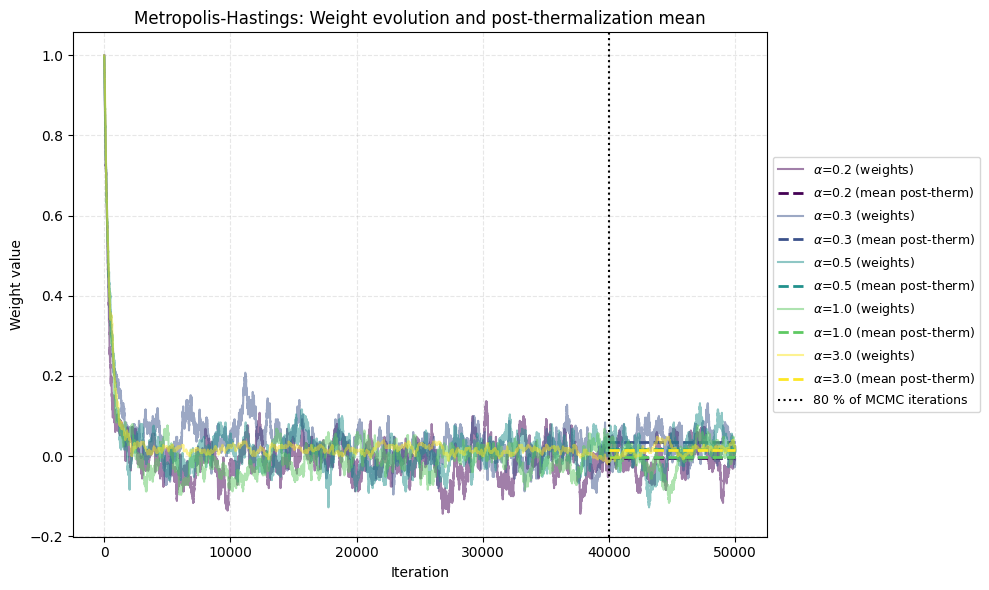

In [16]:
# --- VISUALIZATION : Weights evolution and post-thermalization mean ---
plt.figure(figsize=(10,6))

colors = plt.cm.viridis(np.linspace(0,1,len(alpha_list)))

for i, (alpha, w) in enumerate(zip(alpha_list, wt_mean)):
    plt.plot(w, color=colors[i], alpha=0.5, label=fr'$\alpha$={alpha} (weights)')
    mean_therm = w[-it_therm:].mean(axis=0)
    plt.hlines(mean_therm, xmin=T_max-it_therm, xmax=T_max, 
               color=colors[i], linestyle='--', linewidth=2,
               label=fr'$\alpha$={alpha} (mean post-therm)')

plt.axvline(T_max - it_therm, color='k', linestyle=':', linewidth=1.5, label='80 % of MCMC iterations')
plt.xlabel('Iteration')
plt.ylabel('Weight value')
plt.title('Metropolis-Hastings: Weight evolution and post-thermalization mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
plt.grid(alpha = 0.3, linestyle = '--')
plt.tight_layout()
plt.show()

**Comment**

---

We observe that convergence occurs more easily as $\alpha$ increases, which is expected since a larger $\alpha$ corresponds to more training data. For $\alpha = 3.0$, the overlap is very close to 1, indicating that the student network nearly perfectly recovers $w_*$.

We observe that as $\alpha$ increases, $\langle \vec{w} \rangle$ fluctuates less over the iterations compared to smaller $\alpha$, indicating that the convergence becomes more stable.

Thermalization is also quite rapid: convergence is typically reached after roughly 3,000 iterations. Therefore, running simulations for 10,000 iterations is sufficient to ensure thermalization across all values of $\alpha$ considered in this study.

When comparing with the Huber loss, it is important to note that gradient descent operates in a parameter space of dimension $\mathbb{R}^d$, whereas the Metropolis-Hastings sampler explores a bounded space $\{-1, 1\}^d$. This bounded exploration allows Metropolis-Hastings to return more reliably to the correct $w_*$, especially since the prior distribution is known exactly. As a result, Metropolis-Hastings achieves slightly higher overlaps, lower test errors, and converges in fewer iterations compared to the Huber loss or even the exact MSE.

---

**Ex. 2.2.3 (1 pts):** Imagine now to build a slightly modified version of the Metropolis-Hastings algorithm. In this new version, given the current vector $\boldsymbol{w}$ and a trial vector $\boldsymbol{w}'$, you accept the new configuration $\boldsymbol{w}'$ if and only if $P(\boldsymbol{w}' | \{y^\mu\}_{\mu = 1}^n, \{\boldsymbol{x}^\mu\}_{\mu = 1}^n) \geq P(\boldsymbol{w} | \{y^\mu\}_{\mu = 1}^n, \{\boldsymbol{x}^\mu\}_{\mu = 1}^n)$. Would you still be able to sample the posterior correctly? *Answer succinctly (maximum 2 lines).*

**Solution**

---

No, this modified algorithm would not sample the posterior correctly. By only accepting moves that increase the probability, it prevents exploration of lower-probability regions, violating detailed balance and breaking ergodicity.

---

# Exercise 3 (4pts): Real Data

In this exercise, you will analyze data from two sensors monitoring a manufacturing process, one is $x_1 \in \mathbb{R}$ and used to predict the other $y  \in \mathbb{R}$ (the data is one-dimensional).  
During the training phase, a system failure occurred, producing **outliers** in the training data.  
You will compare the MSE and Huber loss, i.e. **Linear Regression** and **Huber Regression** to study how each model handles such outliers.

Use `scikit-learn` this time, rather than your GD code.


**Ex. 3.1 (0.5pts)** — Loading and plotting the data
Plot the data from the files `train_real_data.csv` and `test_real_data.csv`, each containing columns `x1` and `y`.  
Plot both the training and test sets together.


[INFO] Shape of training data: (5148, 2)
[INFO] Shape of testing data: (1000, 2)


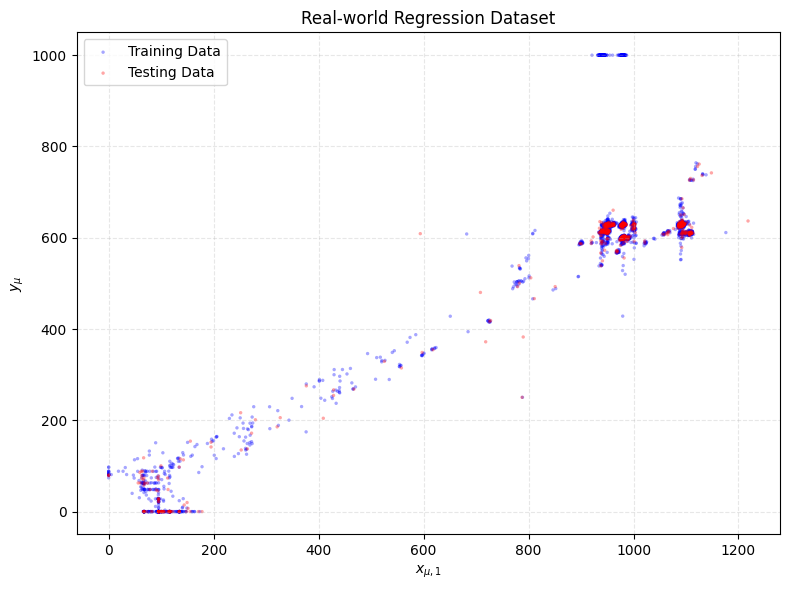

In [17]:
import pandas as pd

# --- Load Datas (CSV) ---
train_real_data_df = pd.read_csv("train_real_data.csv")
test_real_data_df = pd.read_csv("test_real_data.csv")
print("[INFO] Shape of training data:", train_real_data_df.shape)
print("[INFO] Shape of testing data:", test_real_data_df.shape)

# --- Extract features and targets ---
X_tr_real, y_tr_real= train_real_data_df.iloc[:, :-1].values, train_real_data_df.iloc[:, -1].values
X_ts_real, y_ts_real= test_real_data_df.iloc[:, :-1].values, test_real_data_df.iloc[:, -1].values

# --- Visualization : Datasets ---
plt.figure(figsize=(8, 6))
plt.scatter(X_tr_real[:, 0], y_tr_real, color='blue', alpha=0.35, label='Training Data', s=6, edgecolors="none")
plt.scatter(X_ts_real[:, 0], y_ts_real, color='red', alpha=0.35, label='Testing Data', s=6, edgecolors="none")
plt.xlabel(r'$x_{\mu,1}$')
plt.ylabel(r'$y_\mu$')
plt.title('Real-world Regression Dataset')
plt.legend(loc='upper left')
plt.grid(alpha = 0.3, linestyle = '--')
plt.tight_layout()

**Ex. 3.2 (3pts): Estimators and model comparison**

1. Fit both a **Linear Regression** and a **Huber Regression** model using `scikit-learn` on the training data.  
2. Split the **test set** into two halves (50:50). Use one half for validation.  
3. Perform **cross-validation** on the parameter controlling the transition between quadratic and linear loss in the `HuberRegressor` (see the documentation, parameter `epsilon` instead of alpha).  
4. Report the **test MSE** for both models and the chosen `epsilon`.  
5. Plot:
   - training and test data,  
   - prediction lines for both models.

[INFO] Best epsilon found by validation: 1.120
[INFO] Linear Regression Test MSE: 5651.4947
[INFO] Huber Regression Test MSE:  1682.4265


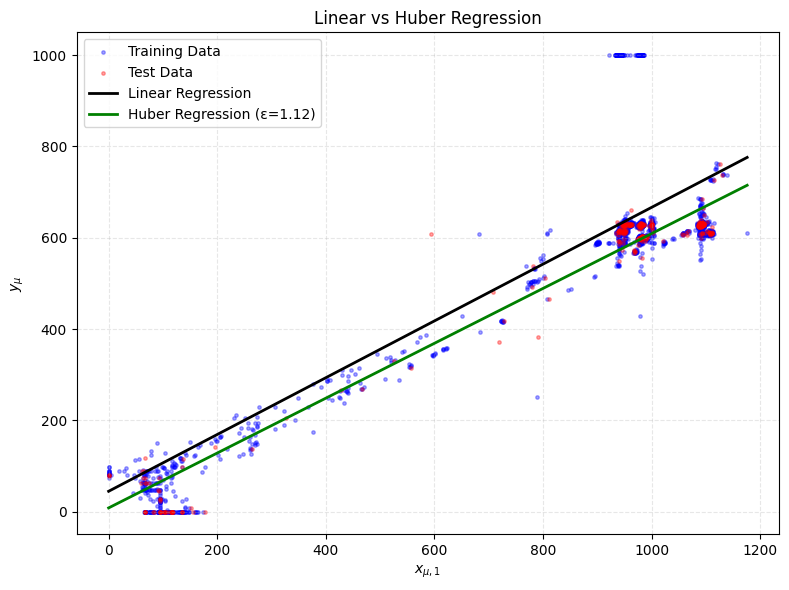

In [18]:
## SOLUTION ##
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.metrics import mean_squared_error

# --- Split test set into two halves ---
X_val, X_test, y_val, y_test = train_test_split(X_ts_real, y_ts_real, test_size=0.5, random_state=0)

# --- Linear Regression ---
# doc : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_tr_real, y_tr_real)

# --- Cross-validation for Huber Regression (on epsilon) ---
# doc : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html#sklearn.linear_model.HuberRegressor
epsilon_values = np.linspace(1.0, 5.0, 1000)
mse_val = []

for eps in epsilon_values:
    huber = HuberRegressor(epsilon=eps, alpha=0.0, max_iter=1000)
    huber.fit(X_tr_real, y_tr_real)
    y_pred_val = huber.predict(X_val)
    mse_val.append(mean_squared_error(y_val, y_pred_val))

best_eps = epsilon_values[np.argmin(mse_val)]
print(f"[INFO] Best epsilon found by validation: {best_eps:.3f}")

best_huber = HuberRegressor(epsilon=best_eps, alpha=0.0, max_iter=1000)
best_huber.fit(X_tr_real, y_tr_real)

# --- VISUALIZATION : Predictions ---
y_pred_lin = lin_reg.predict(X_test)
y_pred_huber = best_huber.predict(X_test)

mse_lin = mean_squared_error(y_test, y_pred_lin)
mse_huber = mean_squared_error(y_test, y_pred_huber)

print(f"[INFO] Linear Regression Test MSE: {mse_lin:.4f}")
print(f"[INFO] Huber Regression Test MSE:  {mse_huber:.4f}")

x_plot = np.linspace(X_tr_real.min(), X_tr_real.max(), 200).reshape(-1, 1)
y_plot_lin = lin_reg.predict(x_plot)
y_plot_huber = best_huber.predict(x_plot)

plt.figure(figsize=(8, 6))
plt.scatter(X_tr_real, y_tr_real, color='blue', alpha=0.35, label='Training Data', s=6)
plt.scatter(X_test, y_test, color='red', alpha=0.35, label='Test Data', s=6)
plt.plot(x_plot, y_plot_lin, color='black', lw=2, label='Linear Regression')
plt.plot(x_plot, y_plot_huber, color='green', lw=2, label=f'Huber Regression (ε={best_eps:.2f})')
plt.xlabel(r'$x_{\mu,1}$')
plt.ylabel(r'$y_\mu$')
plt.title('Linear vs Huber Regression')
plt.legend(loc='upper left')
plt.grid(alpha = 0.3, linestyle = '--')
plt.tight_layout()
plt.show()

**Comment**

---

We choose values of **ε (epsilon)** in the range $[1, \infty)$, with the default being **1.35**. Our goal is to find an optimal value empirically. After several tests, we refocused our search around **ε ≈ 1.1**, which appears to yield the best results.

*Source: [Scikit-learn Documentation – Huber Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html#sklearn.linear_model.HuberRegressor)*

---

**Ex. 3.3 (0.5pts): Discussion**

1. Which estimator performs better? Can you visually inspect the result to speculate which were the outliers?

2. What is different about these regressors from the library compared to the ones from the previous exercises?

**SOLUTION**

---

(1.) The Huber Regressor performs better than the Linear Regression due to the presence of outliers in the real dataset. The Huber model is inherently more robust and less sensitive to extreme values. Numerically, the test MSE of the Huber model is lower than that of the Linear Regression (MSEHuber = 1682.43 < MSELinear = 5651.49), confirming its superior performance. 

Visually, the linear regression line is pulled toward the outliers, whereas the Huber regression line stays closer to the main cluster of data points, capturing the overall trend more accurately. In the graph, the MSE (Linear Regression) line is shifted upward, fitting more outliers, which suggests that outliers are predominantly located toward the top of the visualization. Indeed, we can identify two groups of outliers: one near the bottom-left, close to the inliers, and another in the top-right, far from the inliers. The second group has a stronger influence on the behavior of the MSE.


(2.) Compared to the manually implemented regressors from the previous exercises, the scikit-learn models are far more efficient, stable, and practical. While the custom implementations relied on hand-coded gradient descent, requiring careful tuning of the learning rate and convergence criteria, the library’s models use highly optimized solvers with automatic convergence control, leading to much faster and more reliable results. In addition, the scikit-learn regressors are vectorized and numerically stable, drastically reducing computation time compared to our manual implementations. Overall, the previous exercises were valuable for understanding the underlying optimization mechanics, but the scikit-learn models provide production-level performance with minimal computational cost.

---